### 1. 기본 설정


- 라이브러리

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

warnings.filterwarnings('ignore')

- 불러오기 (전처리 후)

In [9]:
file_path = '../전처리 완료/lendingclub 전처리 완료.csv' 

# 파일이 있는지 확인하고 로드
if os.path.exists(file_path):
    df = pd.read_csv(file_path)
    print("컬럼 목록:", df.columns.tolist())
else:
    print("파일이 없습니다")

display(df.head())

컬럼 목록: ['loan_amnt', 'term', 'int_rate', 'grade', 'home_ownership', 'annual_inc', 'loan_status', 'purpose', 'dti', 'delinq_2yrs', 'fico_range_low', 'pub_rec', 'revol_util']


,loan_amnt,term,int_rate,grade,home_ownership,annual_inc,loan_status,purpose,dti,delinq_2yrs,fico_range_low,pub_rec,revol_util
0,3600.0,36 months,13.99,C,MORTGAGE,55000.0,Fully Paid,debt_consolidation,5.91,0.0,675.0,0.0,29.7
1,24700.0,36 months,11.99,C,MORTGAGE,65000.0,Fully Paid,small_business,16.06,1.0,715.0,0.0,19.2
2,20000.0,60 months,10.78,B,MORTGAGE,63000.0,Fully Paid,home_improvement,10.78,0.0,695.0,0.0,56.2
3,35000.0,60 months,14.85,C,MORTGAGE,110000.0,Current,debt_consolidation,17.06,0.0,785.0,0.0,11.6
4,10400.0,60 months,22.45,F,MORTGAGE,104433.0,Fully Paid,major_purchase,25.37,1.0,695.0,0.0,64.5


- 한글 폰트 깨짐 방지

In [10]:
import platform
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic') 
else:
    # 리눅스
    plt.rc('font', family='NanumGothic')

# 마이너스 기호방지
plt.rcParams['axes.unicode_minus'] = False

### 2. EDA 

#### 1. 피처 엔지니어링 (파생변수) 

1. loan_status_binary : 이진위로 분류

- fully paid(정상 상환) = 0
- charged off(부실/연체) = 1

In [11]:
# 1. loan_status_binary
target_status = ['Fully Paid', 'Charged Off']
df = df[df['loan_status'].isin(target_status)]

loan_status_mapping = {
    'Fully Paid': 0,
    'Charged Off': 1
}

df['loan_status_binary'] = df['loan_status'].map(loan_status_mapping)
df.drop('loan_status', axis=1, inplace=True)

df['loan_status_binary']

0          0
1          0
2          0
4          0
5          0
          ..
2257141    0
2257143    0
2257144    1
2257145    0
2257150    1
Name: loan_status_binary, Length: 1344075, dtype: int64

2. LTI : 내 연봉 대비 대출금이 얼마인가? (대출금 / 연소득)

In [14]:
# 2. LTI (Loan to Income)
# 공식: 대출금액 / 연소득
df['LTI'] = df['loan_amnt'] / df['annual_inc']
df['LTI']

0          0.065455
1          0.380000
2          0.317460
4          0.099585
5          0.351471
             ...   
2257141    0.138462
2257143    0.162618
2257144    0.203822
2257145    0.106667
2257150    0.218182
Name: LTI, Length: 1344075, dtype: float64

3. 등급 수치화: A는 1등급, G는 7등급 (숫자가 클수록 위험)

In [15]:
# 3. 등급 수치화 -->  알파벳 등급을 점수로
# A(우량) = 1점 ~ G(위험) = 7점 (숫자가 클수록 위험함)
grade_dic = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
df['grade_num'] = df['grade'].map(grade_dic)

df['grade_num']

0          3
1          3
2          2
4          6
5          3
          ..
2257141    2
2257143    3
2257144    3
2257145    3
2257150    3
Name: grade_num, Length: 1344075, dtype: int64

4. term 컬럼에서 '36개월 이상' 같은 문자열을 36이라는 숫자열로 변환하고 이름은 그대로사용

In [16]:
# 4. term -> int
# 앞뒤 공백 제거
df['term'] = df['term'].str.strip()
df['term'].unique()

# 'months' 제거 후 숫자로 변환
df['term_num'] = df['term'].str.replace(' months', '').astype(int)
df['term_num'].unique()

df['term_num']

0          36
1          36
2          60
4          60
5          36
           ..
2257141    60
2257143    60
2257144    60
2257145    60
2257150    60
Name: term_num, Length: 1344075, dtype: int64

5. home_ownership: ('MORTGAGE',  'OWN' 소유:0), ('ANY', 'RENT' ,'NONE', 'OTHER' 미소유:1)

In [18]:
# 5. home_ownership 범주화 'MORTGAGE',  'OWN' 소유, 'ANY', 'RENT' ,'NONE', 'OTHER' 미소유
map_home_ownership = {
    'MORTGAGE': 0, 'OWN':0 , 'ANY':1,'RENT': 1, 'NONE': 1, 
    'OTHER' : 1
}
map_home_ownership = df['home_ownership'].map(map_home_ownership)
df['map_home_ownership']=map_home_ownership

df['map_home_ownership']

0          0
1          0
2          0
4          0
5          1
          ..
2257141    0
2257143    0
2257144    0
2257145    1
2257150    1
Name: map_home_ownership, Length: 1344075, dtype: int64

- 파생변수 생성 확인

In [21]:
# 확인
df[['loan_status_binary', 'LTI', 'grade_num', 'term_num', 'map_home_ownership']].head(3)

,loan_status_binary,LTI,grade_num,term_num,map_home_ownership
0,0,0.065455,3,36,0
1,0,0.380000,3,36,0
2,0,0.317460,2,60,0


#### 2. EDA (비교)

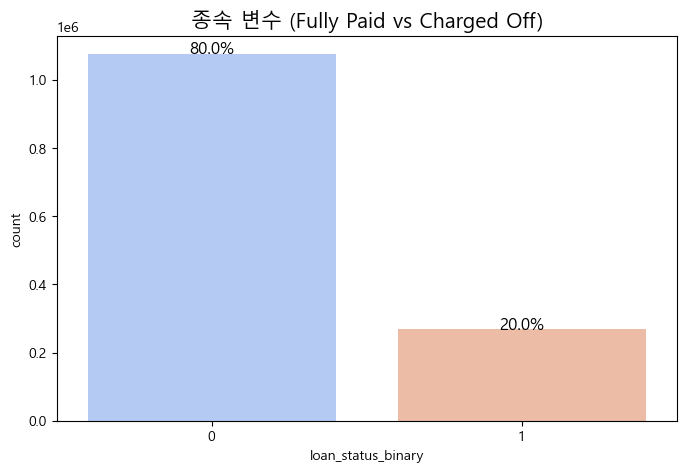

In [22]:
plt.figure(figsize=(8, 5))

# 카운트플롯 사용
ax = sns.countplot(x='loan_status_binary', data=df, palette='coolwarm')

# 비율 표시하는 방법
total = len(df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 1000, 
            f'{height/total:.1%}', ha="center", fontsize=12)

plt.title('종속 변수 (Fully Paid vs Charged Off)', fontsize=15)
plt.show()

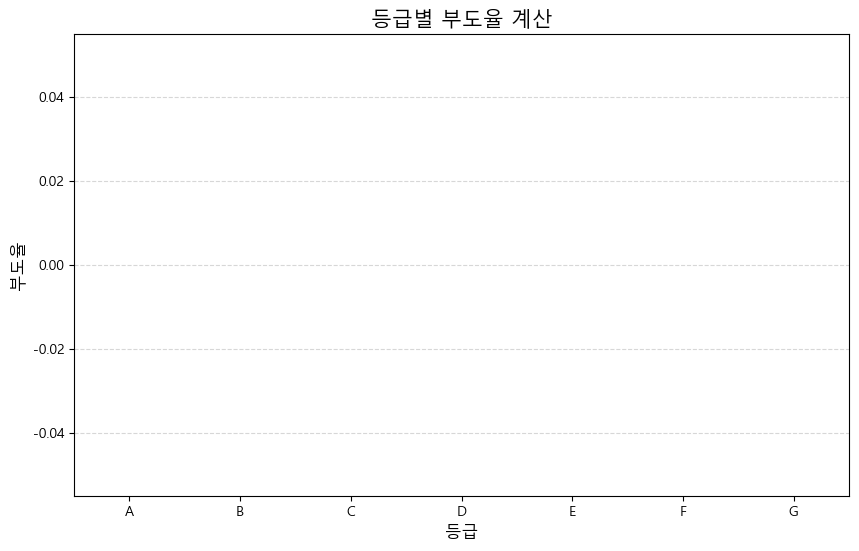

In [ ]:
grade_order = sorted(df['grade'].unique()) # 순서 정렬

# Charged Off / 전체 (비율계산)
default_rates = df.groupby('grade_num')['loan_status_binary'].apply(lambda x: (x == 'Charged Off').mean() * 100).reindex(grade_order)

# 부도율을 계산하는 방법



plt.figure(figsize=(10, 6))

# 바플롯으로
sns.barplot(x=default_rates.index, y=default_rates.values, palette='Reds')

plt.title('등급별 부도율 계산', fontsize=15)
plt.ylabel('부도율(%)', fontsize=12)
plt.xlabel('등급', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
